In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
from astropy.cosmology import Planck15 as cosmo
import emcee
from scipy import optimize as op
import corner

import scipy
import os
os.environ["OMP_NUM_THREADS"] = "8"
from multiprocessing import Pool

import time

from datetime import datetime

In [2]:
c=cte.c
Msun=cte.M_sun

In [3]:
file = open("T1 f2.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

v1=[]
ev1=[]

v2=[]
ev2=[]

v3=[]
ev3=[]

l1=[]
el1=[]

l2=[]
el2=[]

l3=[]
el3=[]


for j in rows:   
    
    ID.append(j[0])
    
    v1.append(float(j[3]))
    ev1.append(float(j[4]))
    v2.append(float(j[5]))
    ev2.append(float(j[6]))
    v3.append(float(j[7]))
    ev3.append(float(j[8]))
    l1.append(float(j[9]))
    el1.append(float(j[10]))
    l2.append(float(j[11]))
    el2.append(float(j[12]))
    l3.append(float(j[13]))
    el3.append(float(j[14]))


In [4]:
v_=[148,218,278]*un.GHz
l__=[500,350,250]*un.um
v=v_.to("Hz").value
l_=(c.to("um/s"))/(np.array([500,350,250])*un.um)
l=l_.to("Hz").value
vf=np.concatenate((v, l))

In [5]:
def tau(z,M_,d_,vf): 
    vf=vf*un.Hz
    d_=d_*un.kpc
    v0=353*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [6]:
def P(vf,T,z):
    vf=vf*un.Hz
    T=T*un.K
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.exp(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [7]:
def modelSv(vf,z,T,M_,d_):
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    
    TAU=tau(z,M_,d_,vf)
    PL=P(vf,T,z)
    
    vf=vf*un.Hz
    T=T*un.K
    d_=d_*un.kpc
    
    O=np.pi*(d_/2)**2 * (D**-2)
    
    S_=O*(1-np.exp(-TAU))*PL
    S=S_.to("mJy")
    return S.value

In [8]:
def A(z,Tc,M_,d_,vf): 

    v0=353*un.GHz
    b=2
    
    Tc=Tc*un.K
    Tvariable=(np.linspace(Tc.value,1000,10000)) *un.K
    
    integrales=[]
    
    for i in vf:
        ARG = modelSv(i,z,Tvariable,M_,d_)*un.mJy *(Tvariable)**-7
        integrales.append(scipy.integrate.trapz(ARG,x=Tvariable))
    
    return integrales

In [9]:
def modelSobs(vf,z,Tc,M_,d_): #Como SPT no entrega Tc tomamos Tc= T-10]
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    TCMB=2.725*un.K
    
    INTEGRAL=A(z,Tc,M_,d_,vf)
    TAU=tau(z,M_,d_,vf)
    
    h=cte.h
    K=cte.k_B
    vf=vf*un.Hz
    d_=d_*un.kpc
    Tc=Tc*un.K
    O=np.pi*(d_/2)**2 * (D**-2)
    model_=[]
    for j in range(len(vf)):
        M1=6 * Tc**6 * INTEGRAL[j]
    
        M2=O * np.exp(-TAU) * (2*h)/(c**2) * (vf[j]**3)/(np.exp(h*vf[j]/(K*TCMB))-1)
        model_.append(((M1+M2)[0]).value)
        
    model=model_*un.mJy

    return model.value

In [10]:
def ml_S(ID,frecsT): #Single
    
    popt,pconv = scipy.optimize.curve_fit(modelSv,vf,frecsT,[2.5,50.,9.5,3.5],bounds=([1,10,8,2],[8,100,11,5])) 
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    plt.figure(figsize=(12,9))

    pm = [z_fit,T_fit,M_fit,d_fit]
    
    x = np.linspace(90,3000,200)*un.GHz
    x = x.to("Hz")
    x = x.value

    y = modelSv(x,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [11]:
def ml_PL_lim(ID,frecsT): #PL
    
    popt,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,35,10.,4.],bounds=([1,20,8,2],[10,50,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]
    
    x = np.linspace(100,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])
    
    

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [12]:
def ml_PL_nolim(ID,frecsT): #PL
    
    popt,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,47,10.,4.],bounds=([1,10,8,2],[10,100,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    popt
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]
    
    x = np.linspace(100,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])
    
    

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [13]:
def lnlike(theta,x,y,yerr,model):
    z,T,M_,d_ = theta
    y=np.array(y)
    yerr=np.array(yerr)
    Sv = modelSv(x,z,T,M_,d_)
    Sobs = modelSobs(x,z,T,M_,d_)
    x = x*un.Hz
    if model=="S": 
        inv_sigma2 = 1.0 / (yerr**2 + (Sv)**2 * np.exp(2*-1))
        lnlike= -0.5 * np.sum((y-(Sv))**2*inv_sigma2 - np.log(inv_sigma2))
    else: 
        inv_sigma2 = 1.0 / (yerr**2 + (Sobs)**2 * np.exp(2*-1))
        lnlike= -0.5 * np.sum((y-(Sobs))**2*inv_sigma2 - np.log(inv_sigma2))
        
    return lnlike
        

In [14]:
def lnprior(theta,model):
    z,T,M,d = theta
    if T>2.73 and z>0 and M>0 and d>0:
        pM= -1 * (M - 9.5)**2 / (2 * 0.5**2) #prior M
        pZ= -1 * (z - 3)**2 / (2 * 2**2) #prior Z 
        pd= -1 * (d - 4)**2 / (2 * 2**2) #prior d
        if model=="S":
            pT= -1 * (T - 55)**2 / (2 * 10**2) #prior T
        if model=="PL nolim":
            pT= -1 * (T - 55)**2 / (2 * 10**2) #prior Tc (como Tc=T-10, automaticamente restamos 10)
        if model=="PL lim":
            pT= -1 * ((T-10) - 35)**2 / (2 * 5**2) #prior Tc
        return pM+pZ+pd+pT
    return -np.inf

In [15]:
def lnprob(theta, x, y, yerr,model):
    lp = lnprior(theta,model)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr,model)

In [16]:
def mcmc_S(ID,frecsT,errfT,model): #recibe con unidades
    
    x = np.linspace(90,2000,200)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    theta,pconv = scipy.optimize.curve_fit(modelSv,vf,frecsT,[2.5,50.,9.5,3.],bounds=([1,10,8,2],[10,100,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = theta
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSv(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 4, 2000 # 3000 iteraciones
    pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(vf,np.array(frecsT),np.array(errfT),model),
                                        pool=pool)

        start = time.time()
        sampler.run_mcmc(pos, 50)
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} minutes".format(multi_time/60))
    
    samples = sampler.chain[:, 40:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],range=[(0,4),(20,65),(7.5,13),(0,6)],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])

In [17]:
def mcmc_PL_nolim(ID,frecsT,errfT,model): #recibe con unidades

    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    theta,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = theta
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 4, 3000 # 6000 iteraciones
    pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(vf,np.array(frecsT),np.array(errfT),model),
                                        pool=pool)
        start = time.time()
        sampler.run_mcmc(pos, 100)
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} minutes".format(multi_time/60))
    
    samples = sampler.chain[:, 90:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],range=[(0,4),(20,65),(7.5,13),(0,6)],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])

In [18]:
def mcmc_PL_lim(ID,frecsT,errfT,model): #recibe con unidades

    
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    theta,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,35.,10.,4.],bounds=([1,20,8,2],[10,50,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = theta
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 4, 2000 # 6000 iteraciones
    pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(vf,np.array(frecsT),np.array(errfT),model),
                                        pool=pool)

        start = time.time()
        sampler.run_mcmc(pos, 50)
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} minutes".format(multi_time/60))

    samples = sampler.chain[:, 40:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],range=[(0,10),(20,65),(7.5,13),(0,6)],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])
  

In [19]:
def test_S_su(ID,frecsT,z_su,T_su,M_su,d_su): #d_su es un valor fijo, porque en la tabla 2 no se enrega d
    x = np.linspace(90,3000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    plt.figure(figsize=(12,9))


    y  = modelSv(x,z_su,T_su,M_su,d_su)
    
    

    plt.plot(x,y,label="Single Su")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$zSu:{},TSu:{},MSu:{},dSu:{}$".format(np.round(z_su,2),np.round(T_su,2),np.round(M_su,2),np.round(d_su,2)),(10**11,1),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    #plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [20]:
def test_PL_su(ID,frecsT,z_su,T_su,M_su,d_su): #d_su es un valor fijo, porque en la tabla 2 no se enrega d
    x = np.linspace(90,3000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    plt.figure(figsize=(12,9))


    y  = modelSobs(x,z_su,T_su,M_su,d_su)
    
    

    plt.plot(x,y,label="PL Su")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$zSu:{},TSu:{},MSu:{},dSu:{}$".format(np.round(z_su,2),np.round(T_su,2),np.round(M_su,2),np.round(d_su,2)),(10**11,1),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    #plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

ACT-S J0011-0018

In [21]:
frecs0T=[v1[0],v2[0],v3[0],l1[0],l2[0],l3[0]]
errf0T=[ev1[0],ev2[0],ev3[0],el1[0],el2[0],el3[0]]

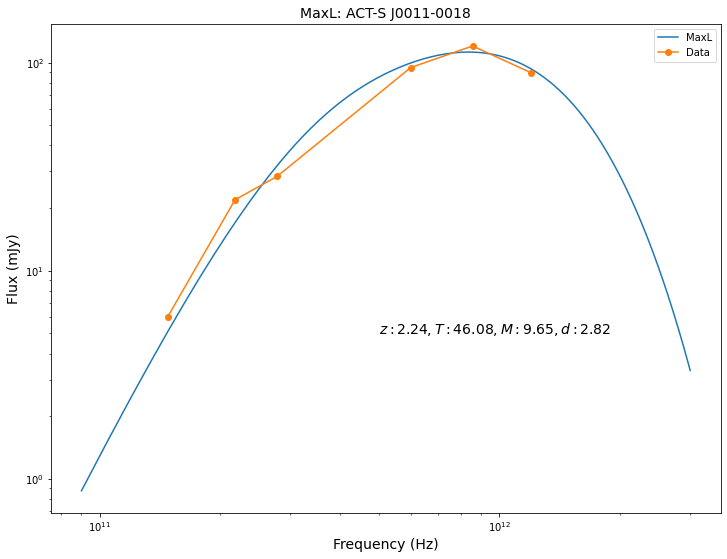

In [22]:
ml_S(ID[0],frecs0T) #maxima semejanza para Single

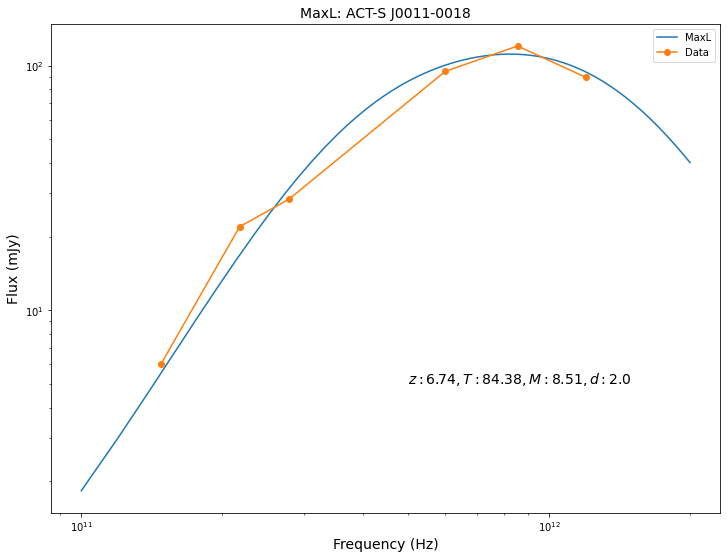

In [23]:
ml_PL_nolim(ID[0],frecs0T)  #maxima semejanza para PL sin limites, es decir, modelo sin tomar Tc entre 20 y 50K

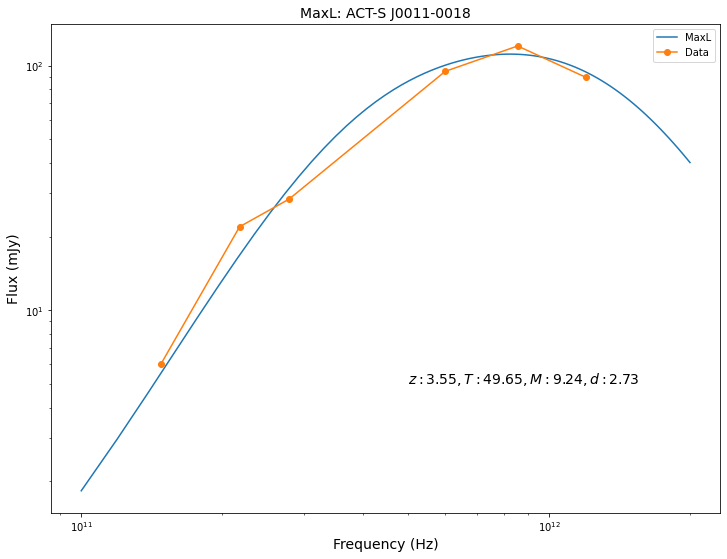

In [24]:
ml_PL_lim(ID[0],frecs0T)  #maxima semejanza para PL con limites, es decir, modelo tomando Tc entre 20 y 50K

Multiprocessing took 6.5 minutes
0:06:32.383153


<Figure size 864x648 with 0 Axes>

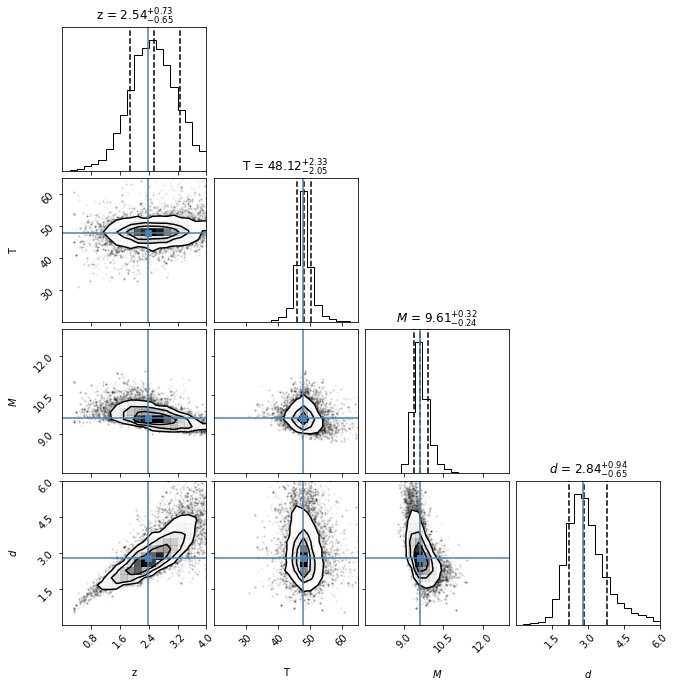

In [25]:
startTime=datetime.now()
mcmc_S(ID[0],frecs0T,errf0T,"S") 
print(datetime.now()-startTime) 

Multiprocessing took 6.1 minutes
0:06:10.609859


<Figure size 864x648 with 0 Axes>

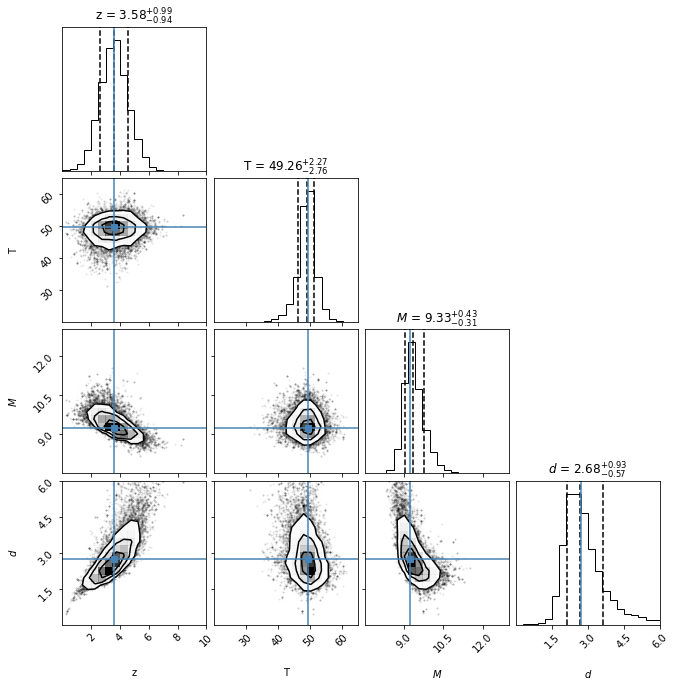

In [26]:
startTime=datetime.now()
mcmc_PL_lim(ID[0],frecs0T,errf0T,"PL lim") 
print(datetime.now()-startTime) 

In [27]:
frecs1T=[v1[1],v2[1],v3[1],l1[1],l2[1],l3[1]]
errf1T=[ev1[1],ev2[1],ev3[1],el1[1],el2[1],el3[1]]

Multiprocessing took 6.4 minutes
0:06:25.640999


<Figure size 864x648 with 0 Axes>

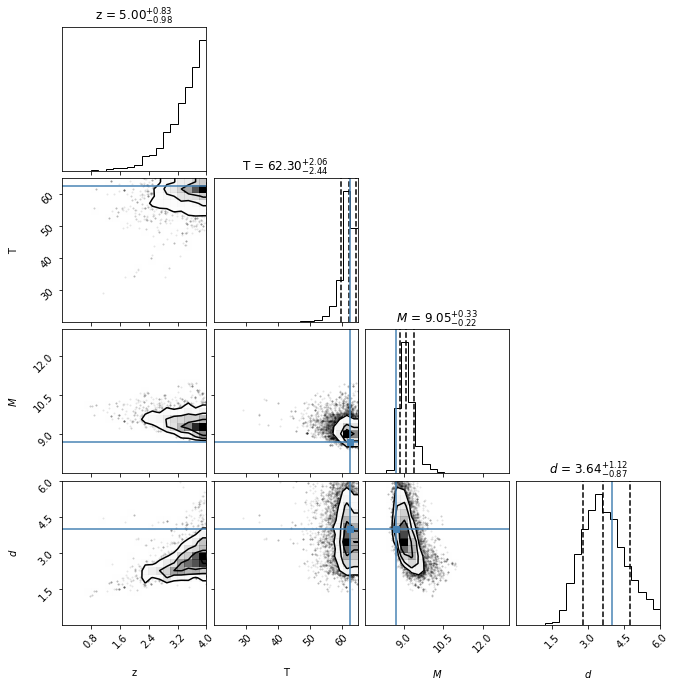

In [28]:
startTime=datetime.now()
mcmc_S(ID[1],frecs1T,errf1T,"S") 
print(datetime.now()-startTime) 

Multiprocessing took 6.4 minutes
0:06:22.950246


<Figure size 864x648 with 0 Axes>

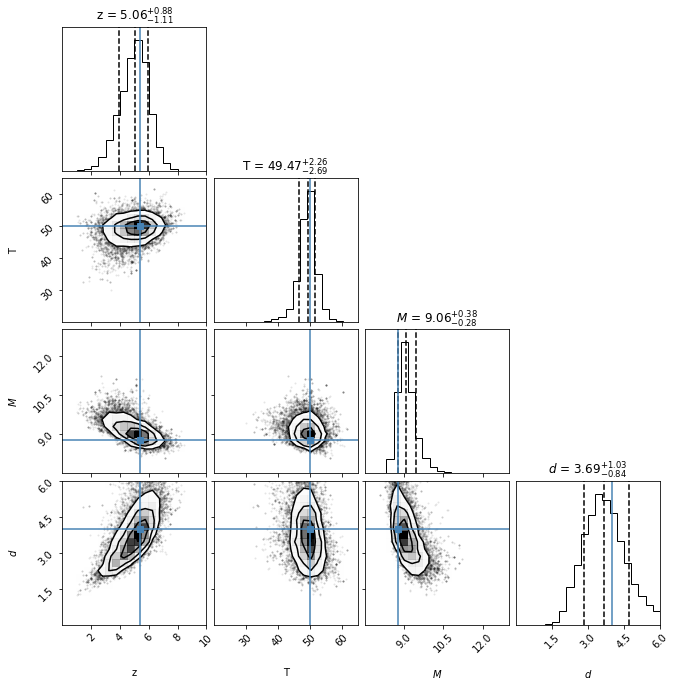

In [29]:
startTime=datetime.now()
mcmc_PL_lim(ID[1],frecs1T,errf1T,"PL lim") 
print(datetime.now()-startTime) 

De aquí en adelante se repiten las funciones en tods las galaxias de ACT.

ACT-S J0038_0022

In [30]:
frecs2T=[v1[2],v2[2],v3[2],l1[2],l2[2],l3[2]]
errf2T=[ev1[2],ev2[2],ev3[2],el1[2],el2[2],el3[2]]

Multiprocessing took 6.6 minutes
0:06:34.643284


<Figure size 864x648 with 0 Axes>

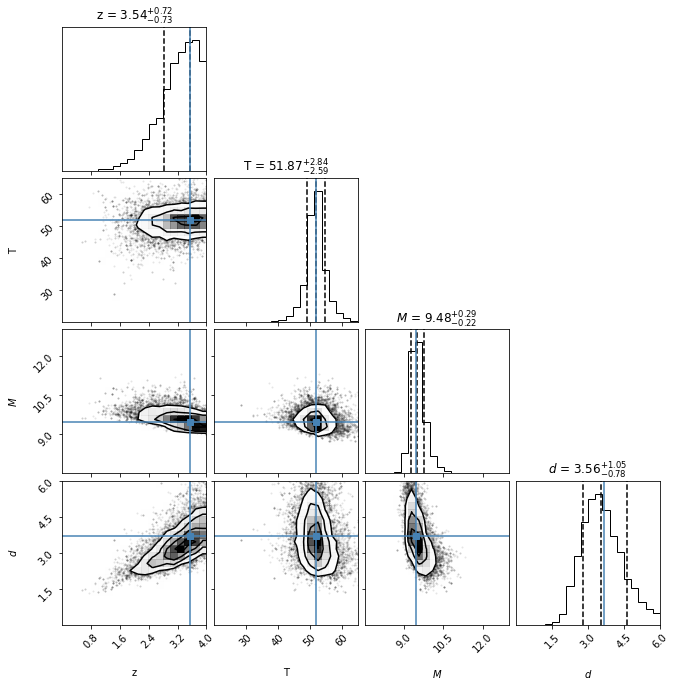

In [31]:
startTime=datetime.now()
mcmc_S(ID[2],frecs2T,errf2T,"S") 
print(datetime.now()-startTime) 

Multiprocessing took 6.4 minutes
0:06:32.274834


<Figure size 864x648 with 0 Axes>

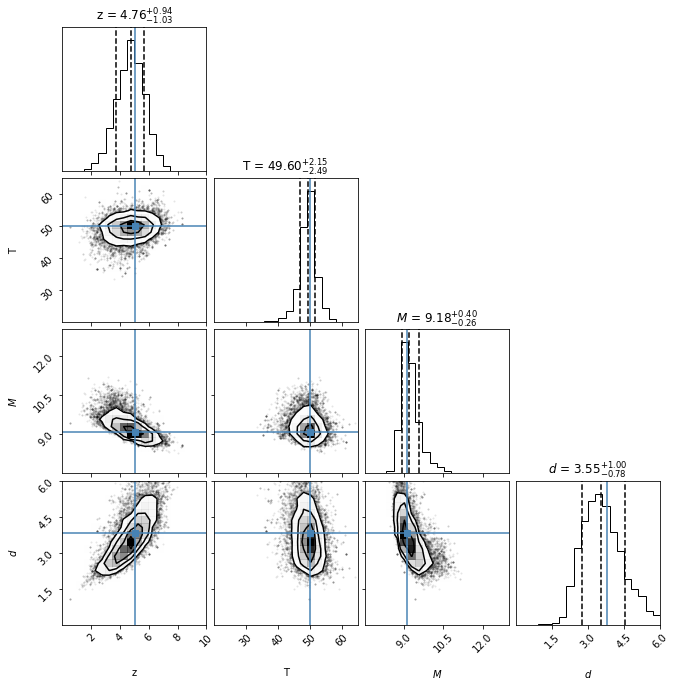

In [32]:
startTime=datetime.now()
mcmc_PL_lim(ID[2],frecs2T,errf2T,"PL lim") 
print(datetime.now()-startTime) 

ACT-S J0039+0024

In [33]:
frecs3T=[v1[3],v2[3],v3[3],l1[3],l2[3],l3[3]]
errf3T=[ev1[3],ev2[3],ev3[3],el1[3],el2[3],el3[3]]

Multiprocessing took 6.4 minutes
0:06:24.490794


<Figure size 864x648 with 0 Axes>

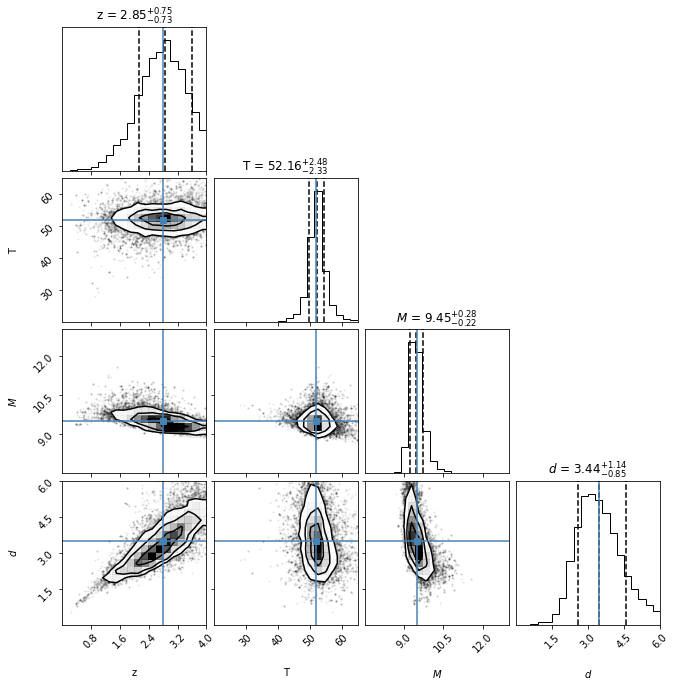

In [34]:
startTime=datetime.now()
mcmc_S(ID[3],frecs3T,errf3T,"S") 
print(datetime.now()-startTime) 

In [36]:
startTime=datetime.now()
mcmc_PL_lim(ID[3],frecs3T,errf3T,"PL Lim") 
print(datetime.now()-startTime) 

emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:


  params:
  params:
  params:
  params:   params:  params:    params: [ 2.49915034 36.30176875  9.62250632  3.99959771] [ 2.49921978 36.30231186  9.62289024  3.99926647][ 2.49981429 36.30042486  9.62156655  4.00052817] [ 2.49810377 36.30126568  9.62295288  4.00027736]
[ 2.49944217 36.30159231  9.6207122   3.99904531]


[ 2.50002953 36.30058435  9.62141012  3.9993482 ]  args:

  args:   args:  args:  args:    args:   (array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,

Traceback (most recent call last):


  args: 



  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


   exception:

Traceback (most recent call last):


  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')
{}

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


Traceback (most recent call last):


  kwargs:(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')

UnboundLocalError: local variable 'pT' referenced before assignment



  kwargs:

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


 emcee: Exception while calling your likelihood function:

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)
  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


  exception:{}

Traceback (most recent call last):


UnboundLocalError: local variable 'pT' referenced before assignment
UnboundLocalError: local variable 'pT' referenced before assignment


  kwargs:

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  params:{}emcee: Exception while calling your likelihood function:
 

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


  exception:


  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


 {}
emcee: Exception while calling your likelihood function:


[ 2.49858835 36.30195687  9.62339727  4.00065629]  params:

Traceback (most recent call last):
UnboundLocalError: local variable 'pT' referenced before assignment


  exception: 

Traceback (most recent call last):


  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)



  exception:

[ 2.50217119 36.29908651  9.62300026  3.99983636]

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  args:

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)
Traceback (most recent call last):
Traceback (most recent call last):


  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT
  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


  args:emcee: Exception while calling your likelihood function:

UnboundLocalError: local variable 'pT' referenced before assignment


(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)



   params:

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


UnboundLocalError: local variable 'pT' referenced before assignment


emcee: Exception while calling your likelihood function:  params:

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)
  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


  kwargs:
(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')

UnboundLocalError: local variable 'pT' referenced before assignment


emcee: Exception while calling your likelihood function:

  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


  params: 


UnboundLocalError: local variable 'pT' referenced before assignment


 
{}emcee: Exception while calling your likelihood function:[ 2.4990191  36.29969989  9.62259178  4.00000213]emcee: Exception while calling your likelihood function:  params:  kwargs: 

  {}


  exception:  args:[ 2.49926478 36.29931989  9.62207689  4.00013861]  params:  exception:
  params:  
 


Traceback (most recent call last):


   args:[ 2.49827667 36.30178749  9.6239663   4.00064311]

Traceback (most recent call last):
  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


[ 2.49976941 36.30195225  9.62327704  4.00166732](array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim') [ 2.50049794 36.30072207  9.62218795  4.00095422][ 2.49885637 36.30267359  9.62080673  4.00088417]

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')  args:

UnboundLocalError: local variable 'pT' referenced before assignment


  kwargs:


  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


 
  args:

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)



  kwargs:emcee: Exception while calling your likelihood function:  args:   args:

UnboundLocalError: local variable 'pT' referenced before assignment
  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


 (array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')  
(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')emcee: Exception while calling your likelihood function:
(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim'){}  params:
 

  kwargs:
  params:[ 2.49836

Traceback (most recent call last):


  args:
   args:   exception:{} 

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)



(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')

Traceback (most recent call last):



(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')

  exception:
  kwargs:  kwargs:


  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  kwargs: 

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)
  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT
Traceback (most recent call last):
UnboundLocalError: local variable 'pT' referenced before assignment
  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


{}{} {}emcee: Exception while calling your likelihood function:


Traceback (most recent call last):


  exception:{}


  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


Traceback (most recent call last):


  params:

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


  exception: 

  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


[ 2.49905622 36.30117762  9.6240778   3.99886368]

UnboundLocalError: local variable 'pT' referenced before assignment


  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT
  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


emcee: Exception while calling your likelihood function:

  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT
Traceback (most recent call last):
UnboundLocalError: local variable 'pT' referenced before assignment




  exception:  params:

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)
UnboundLocalError: local variable 'pT' referenced before assignment


  exception:emcee: Exception while calling your likelihood function:  args:


  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


Traceback (most recent call last):


  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


emcee: Exception while calling your likelihood function:

UnboundLocalError: local variable 'pT' referenced before assignment


  params:

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


[ 2.49989169 36.30239495  9.62232667  4.00080032]

Traceback (most recent call last):


(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim') 

  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT



emcee: Exception while calling your likelihood function:

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


[ 2.49959756 36.29913664  9.62368478  4.00106384]



  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


  kwargs:

UnboundLocalError: local variable 'pT' referenced before assignment



  args:


  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


emcee: Exception while calling your likelihood function:   args:

UnboundLocalError: local variable 'pT' referenced before assignment


  params: 
  

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


  params:  params:(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')

  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


  
emcee: Exception while calling your likelihood function:

UnboundLocalError: local variable 'pT' referenced before assignment


  kwargs:[ 2.49813986 36.30169363  9.62295814  3.99919162][ 2.49844307 36.30204486  9.62124659  3.99827444]emcee: Exception while calling your likelihood function:
[ 2.49929981 36.30191912  9.62305942  3.99968151]
  params:

  args: {}   params:

   exception:  args:   args:(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim') (array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim') 

[ 2.4996574  36.30174619  9.62352166  3.9990654 ](array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')

Traceback (most recent call last):


  kwargs:
{}
 

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)



  kwargs:

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')  exception:

  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


[ 2.50188023 36.2999376   9.62234969  4.00039506]  args:{} 
  kwargs:


UnboundLocalError: local variable 'pT' referenced before assignment




{}   kwargs: 
emcee: Exception while calling your likelihood function:  args:  exception: {}  exception:

Traceback (most recent call last):


 
{}

(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')  exception:(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')
  params:



  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


Traceback (most recent call last):


  kwargs:  exception:   kwargs:

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)
Traceback (most recent call last):


[ 2.49968076 36.30134821  9.62281126  3.99960885]

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)
  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


{}

UnboundLocalError: local variable 'pT' referenced before assignment
  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT




emcee: Exception while calling your likelihood function:

Traceback (most recent call last):


  args:

UnboundLocalError: local variable 'pT' referenced before assignment


  exception:

  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


Traceback (most recent call last):


UnboundLocalError: local variable 'pT' referenced before assignment


  params:

Traceback (most recent call last):


emcee: Exception while calling your likelihood function:

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


emcee: Exception while calling your likelihood function:

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim'){}

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)
  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


[ 2.49854386 36.30042681  9.62242504  4.00113414]

  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


  params:

  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


  kwargs:   exception:

UnboundLocalError: local variable 'pT' referenced before assignment
UnboundLocalError: local variable 'pT' referenced before assignment
UnboundLocalError: local variable 'pT' referenced before assignment



[ 2.49947666 36.30108284  9.62421983  3.99894091] emcee: Exception while calling your likelihood function:  params:


Traceback (most recent call last):



{}

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


emcee: Exception while calling your likelihood function:  args:  params:


  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


 
   exception:[ 2.49964598 36.29900203  9.62367336  4.00071179]  args: 
(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')

  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


[ 2.49882234 36.30043774  9.62221406  4.00048346] 

  kwargs:

UnboundLocalError: local variable 'pT' referenced before assignment



  args:(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')   params: 

Traceback (most recent call last):



{}

  args:(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  kwargs: 
   exception:


  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim'){}

Traceback (most recent call last):
  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT


  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  kwargs:

UnboundLocalError: local variable 'pT' referenced before assignment


  exception:

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


Traceback (most recent call last):


{}

  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT
  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


UnboundLocalError: local variable 'pT' referenced before assignment


  exception:

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)
  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT



[ 2.50037336 36.30070406  9.6229039   3.99964554]  kwargs:


Traceback (most recent call last):


   args:

  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


{} 

  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)


(array([1.48000000e+11, 2.18000000e+11, 2.78000000e+11, 5.99584916e+11,
       8.56549880e+11, 1.19916983e+12]), array([  6.14,  19.5 ,  35.32, 162.11, 152.6 , 140.84]), array([1.76, 2.56, 6.24, 7.29, 6.34, 6.51]), 'PL Lim')


  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT



  exception:

UnboundLocalError: local variable 'pT' referenced before assignment


  kwargs:
 

UnboundLocalError: local variable 'pT' referenced before assignment


{}
  exception:


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)
  File "/home/cvargas/miniconda2/envs/py39/lib/python3.9/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT
  File "/tmp/ipykernel_13562/3646403905.py", line 2, in lnprob
    lp = lnprior(theta,model)
UnboundLocalError: local variable 'pT' referenced before assignment
  File "/tmp/ipykernel_13562/1769035760.py", line 13, in lnprior
    return pM+pZ+pd+pT
UnboundLocalError: local variable 'pT' referenced before assignment


UnboundLocalError: local variable 'pT' referenced before assignment

<Figure size 864x648 with 0 Axes>

ACT-S J0044+0118

In [37]:
frecs4T=[v1[4],v2[4],v3[4],l1[4],l2[4],l3[4]]
errf4T=[ev1[4],ev2[4],ev3[4],el1[4],el2[4],el3[4]]

Multiprocessing took 6.2 minutes
0:06:15.436764


<Figure size 864x648 with 0 Axes>

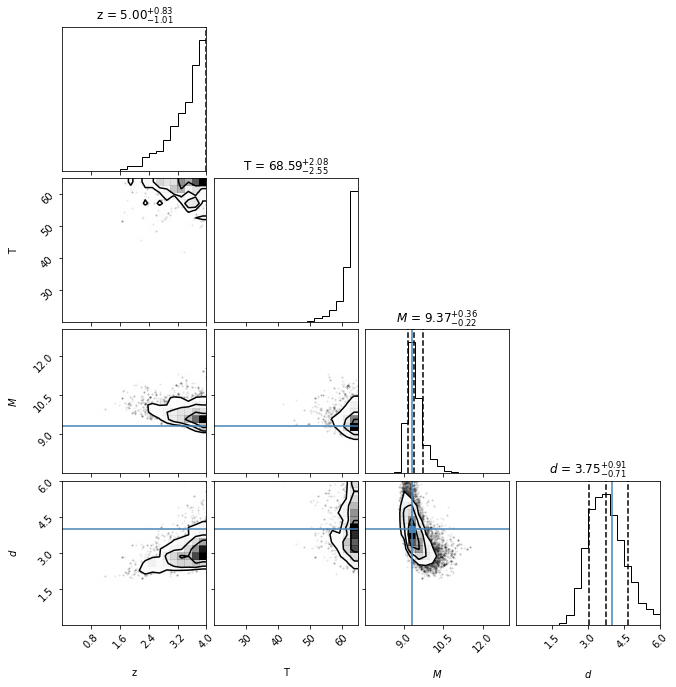

In [38]:
startTime=datetime.now()
mcmc_S(ID[4],frecs4T,errf4T,"S") 
print(datetime.now()-startTime)

Multiprocessing took 6.0 minutes
0:05:59.149532


<Figure size 864x648 with 0 Axes>

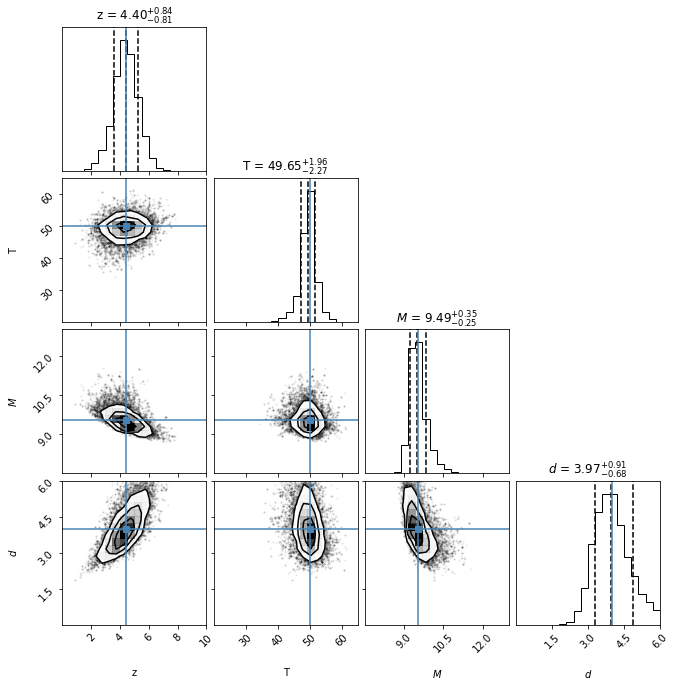

In [39]:
startTime=datetime.now()
mcmc_PL_lim(ID[4],frecs4T,errf4T,"PL lim") 
print(datetime.now()-startTime)

ACT-S J0045_0001

In [40]:
frecs5T=[v1[5],v2[5],v3[5],l1[5],l2[5],l3[5]]
errf5T=[ev1[5],ev2[5],ev3[5],el1[5],el2[5],el3[5]]

Multiprocessing took 5.8 minutes
0:05:47.841934


<Figure size 864x648 with 0 Axes>

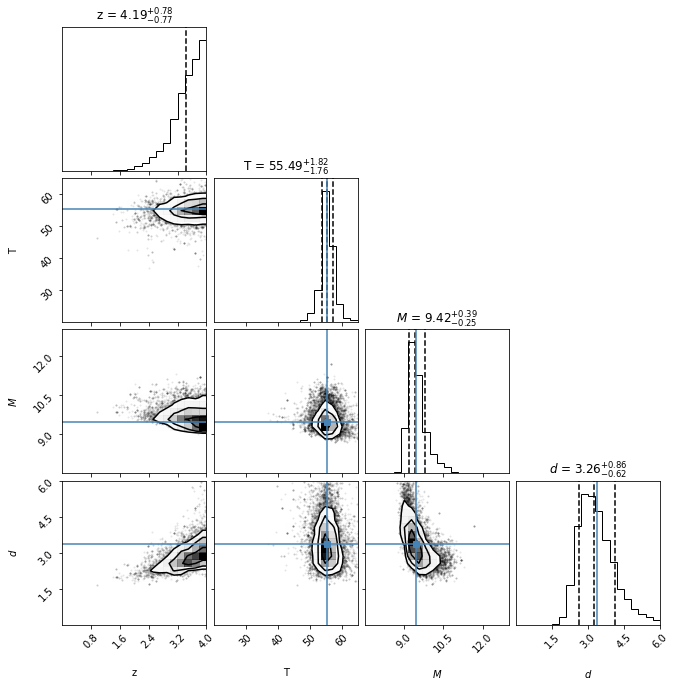

In [41]:
startTime=datetime.now()
mcmc_S(ID[5],frecs5T,errf5T,"S") 
print(datetime.now()-startTime)

Multiprocessing took 5.8 minutes
0:05:56.262950


<Figure size 864x648 with 0 Axes>

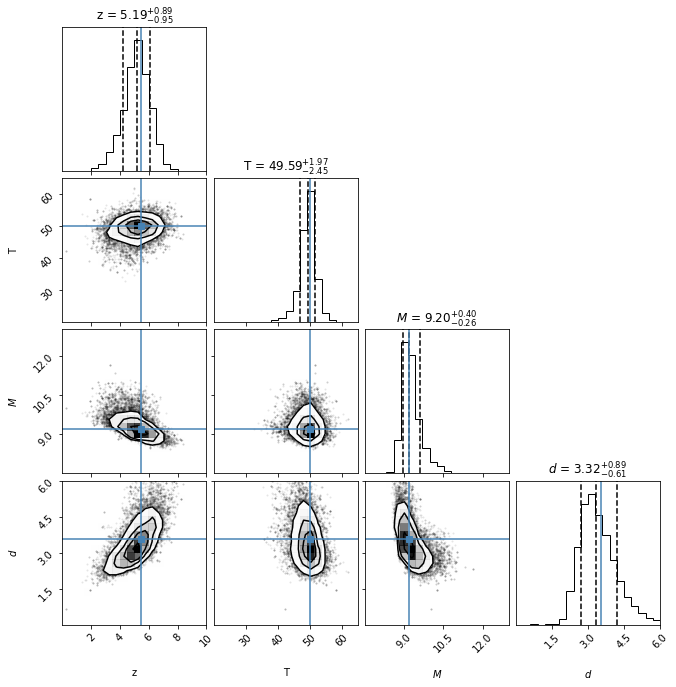

In [42]:
startTime=datetime.now()
mcmc_PL_lim(ID[5],frecs5T,errf5T,"PL lim") 
print(datetime.now()-startTime)

ACT-S J0107+0001

In [43]:
frecs6T=[v1[6],v2[6],v3[6],l1[6],l2[6],l3[6]]
errf6T=[ev1[6],ev2[6],ev3[6],el1[6],el2[6],el3[6]]

Multiprocessing took 5.8 minutes
0:05:47.267835


<Figure size 864x648 with 0 Axes>

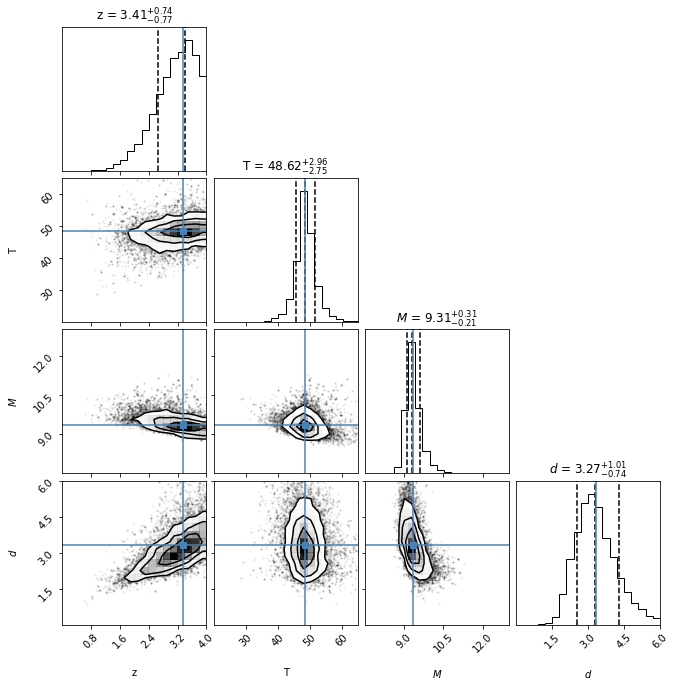

In [44]:
startTime=datetime.now()
mcmc_S(ID[6],frecs6T,errf6T,"S") 
print(datetime.now()-startTime)

Multiprocessing took 5.8 minutes
0:05:52.626121


<Figure size 864x648 with 0 Axes>

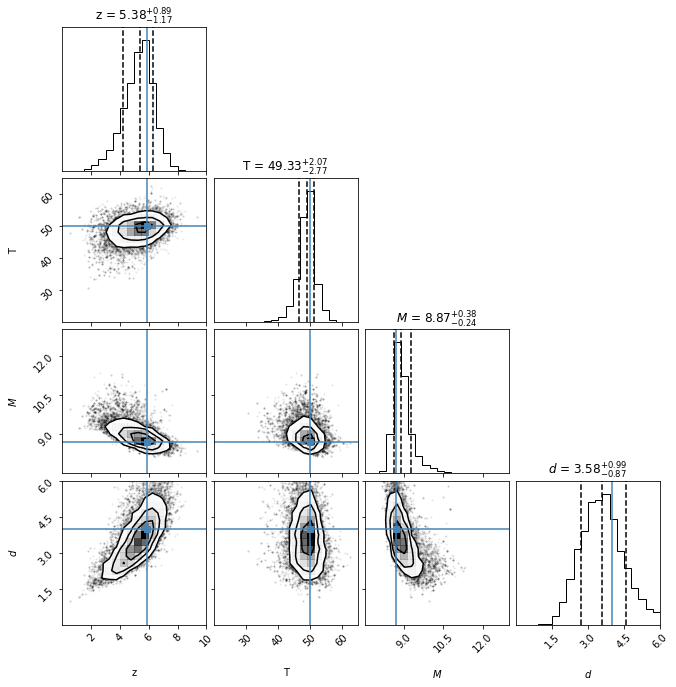

In [45]:
startTime=datetime.now()
mcmc_PL_lim(ID[6],frecs6T,errf6T,"PL lim") 
print(datetime.now()-startTime)

ACT-S J0116_0004

In [46]:
frecs7T=[v1[7],v2[7],v3[7],l1[7],l2[7],l3[7]]
errf7T=[ev1[7],ev2[7],ev3[7],el1[7],el2[7],el3[7]]

Multiprocessing took 5.8 minutes
0:05:47.221193


<Figure size 864x648 with 0 Axes>

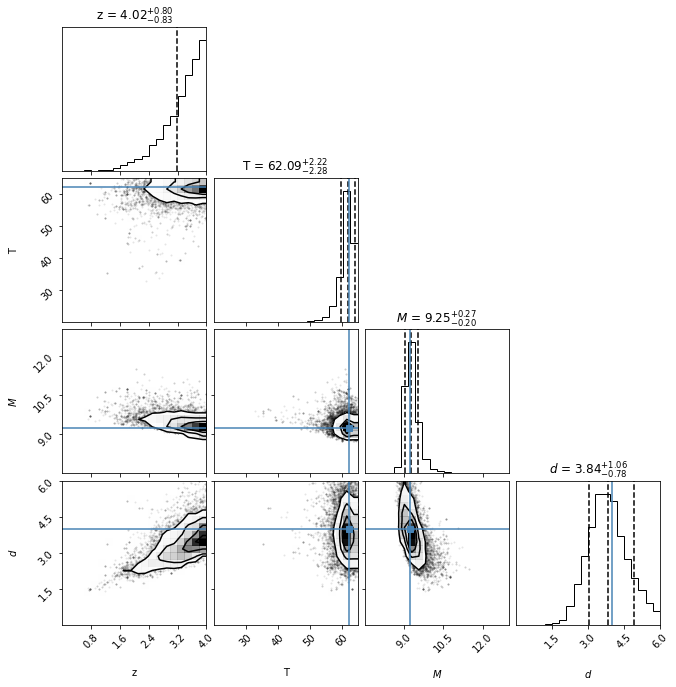

In [47]:
startTime=datetime.now()
mcmc_S(ID[7],frecs7T,errf7T,"S") 
print(datetime.now()-startTime)

Multiprocessing took 5.7 minutes
0:05:44.002589


<Figure size 864x648 with 0 Axes>

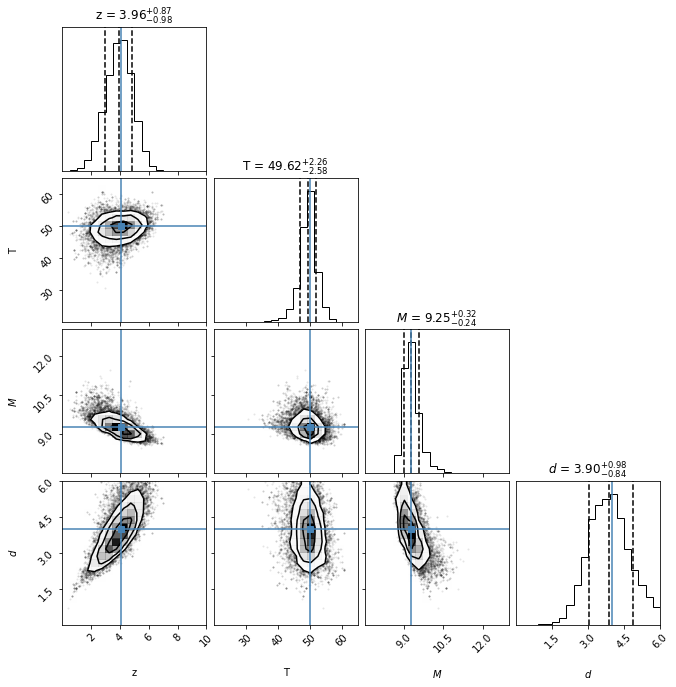

In [48]:
startTime=datetime.now()
mcmc_PL_lim(ID[7],frecs7T,errf7T,"PL lim") 
print(datetime.now()-startTime)

ACT-S J0210+0016

In [49]:
frecs8T=[v1[8],v2[8],v3[8],l1[8],l2[8],l3[8]]
errf8T=[ev1[8],ev2[8],ev3[8],el1[8],el2[8],el3[8]]

Multiprocessing took 5.7 minutes


0:05:44.888337


<Figure size 864x648 with 0 Axes>

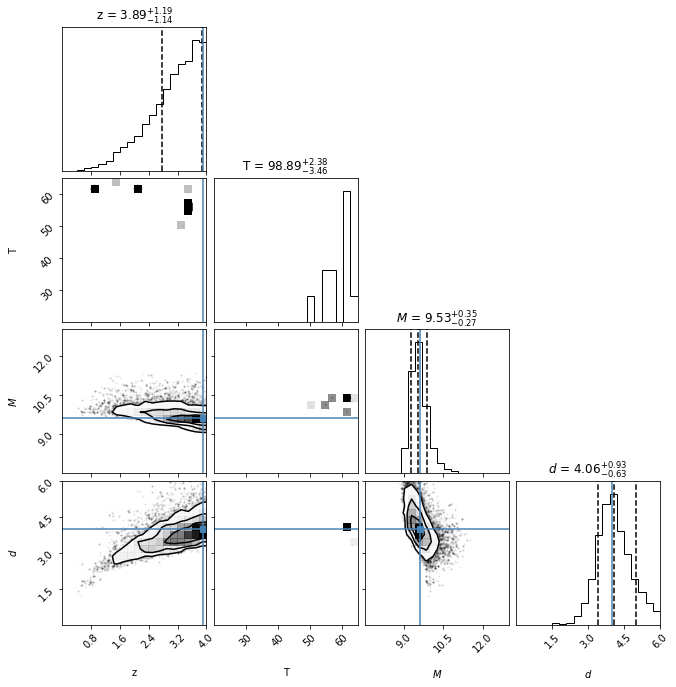

In [50]:
startTime=datetime.now()
mcmc_S(ID[8],frecs8T,errf8T,"S") 
print(datetime.now()-startTime)

Multiprocessing took 5.7 minutes
0:05:43.871861


<Figure size 864x648 with 0 Axes>

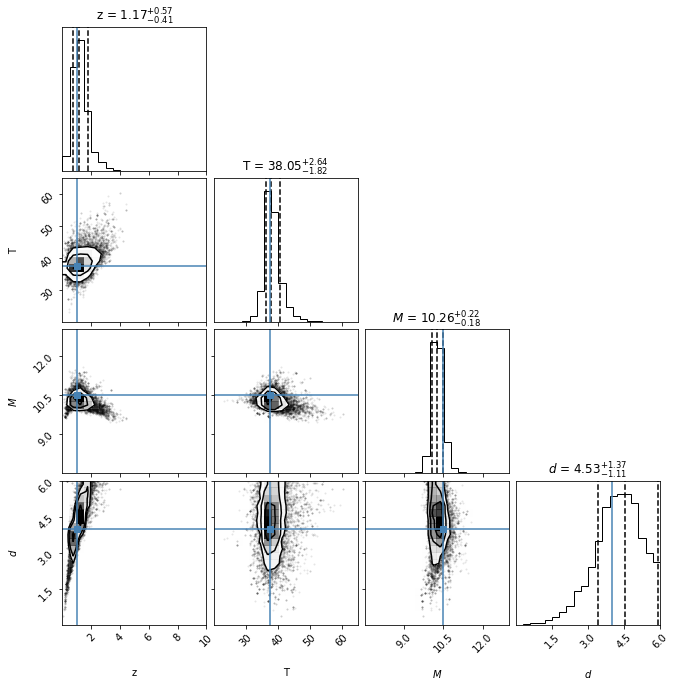

In [51]:
startTime=datetime.now()
mcmc_PL_lim(ID[8],frecs8T,errf8T,"PL lim") 
print(datetime.now()-startTime)